# Geo877 Spatial Algorithms - Group Alivand
### Extracting Scenic Routes from VGI Data Sources 
Please enter all your code here, or in the python file with the same name (for classes and other "background" code).

In [6]:
from Geo877_Alivand import *
import os
import getpass
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import MultiLineString, Point, LineString
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

In [7]:
# Use this to get the current user name, as it will be needed later to access files
user_name = getpass.getuser()

## Setup

Setting up the network

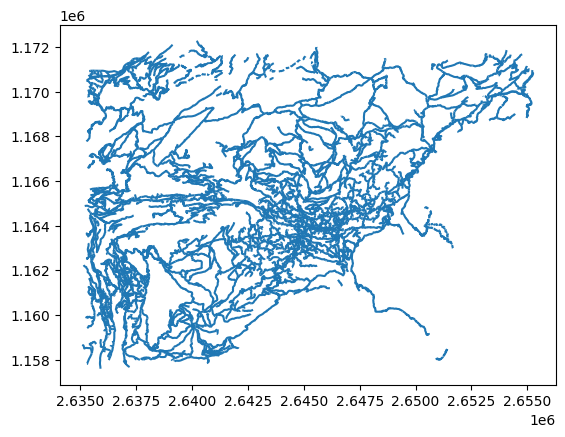

In [9]:
gdf = gpd.read_file('Roads_small.gpkg')
graph = preprocess_gdf(gdf)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
plt.show()

In [17]:
components = dfs.find_connected_components(graph)
# find largest component
largest_component = dfs.get_largest_component(components)
dfs.filter_graph(components, largest_component, gdf)


NameError: name 'dfs_component' is not defined

## Graph processing
Processing the original gpkg file to generates graph.
### Build temporary graph
We built a temporary graph based on the original gpkg file. We develop three different kinds of data structure to store graph. They are adjacency list, adjacency matrix and edge list.

## Data loading

Loading the required datasets for the analysis.

### Load the land use statistic

The land use statistic (LUS) is in csv format.

In [3]:
# Create a path to the CSV file of the land use statistic
csv_file_path = os.path.join('/Users', user_name, 'Documents', 'GitHub', 'G877_Alivand', 'arealstatistik_Grindelwald.csv')

# Load land use statistic data
arealstatistik_GW = pd.read_csv(csv_file_path, sep=';')
#print(arealstatistik_GW)
#arealstatistik_GW.info()

### Load the DHM25

The DHM25 is in geojson format.

In [4]:
# Create a path to the file of the DHM25
dhm25_file_path = os.path.join('/Users', user_name, 'Documents', 'GitHub', 'G877_Alivand', 'DHM25_Grindelwald.geojson')

# Load DHM25 data
dhm25 = gpd.read_file(dhm25_file_path)
#print(dhm25)

### Populating the classes

In [5]:
# Add the data into the Point class and create an attribute containing the land use category
points_LUS = []

for x in range(len(arealstatistik_GW)):
    a = (Point(arealstatistik_GW['E_COORD'].iloc[x], arealstatistik_GW['N_COORD'].iloc[x]))
    a.cat = arealstatistik_GW['AS18_4'].iloc[x]
    points_LUS.append(a)

print(f'The first 5 points are: {points_LUS[:5]}')
print(f'There are {len(points_LUS)} points in the dataset.')

The first 5 points are: [Point(x=2620000, y=1150100), Point(x=2620000, y=1151400), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620000, y=1152200)]
There are 120701 points in the dataset.


In [6]:
# Split up the DHM25 geometry to fit in our own Point class
dhm25['E_COORD'] = dhm25['geometry'].x.round(1)
dhm25['N_COORD'] = dhm25['geometry'].y.round(1)
dhm25['Z_COORD'] = dhm25['geometry'].z.round(0).astype(int)
#print(dhm25)

# Create points from this data
points_DHM25 = []

for i in range(len(dhm25)):
    point = Point(dhm25['E_COORD'].iloc[i], dhm25['N_COORD'].iloc[i])
    elevation = dhm25['Z_COORD'].iloc[i]
    points_DHM25.append({'point': point, 'elevation': elevation})

print(f'The first 5 points are: {points_DHM25[:5]}')
print(f'There are {len(points_DHM25)} points in the dataset.')
print(f'The elevation of the first point is {points_DHM25[0]["elevation"]}m.a.s.l.')

The first 5 points are: [{'point': Point(x=2625485.9, y=1172295.3), 'elevation': 1584}, {'point': Point(x=2627831.3, y=1172885.9), 'elevation': 1505}, {'point': Point(x=2639148.4, y=1170993.8), 'elevation': 1431}, {'point': Point(x=2648728.1, y=1170739.1), 'elevation': 2928}, {'point': Point(x=2652621.9, y=1170375.0), 'elevation': 1713}]
There are 4280 points in the dataset.
The elevation of the first point is 1584m.a.s.l.


## Visibility analysis

Conducting the analysis of "scenicness" twice, once based on land use statistics and queen neighbourhood (all 8 neighbouring fields) scores and once based on heights and a vicinity radius.
### Land use statistic scenicness

This calculates individual closest points, the points' neighbourhoods, and the landcover values which are then scored according to their (non)scenicness.

In [7]:
# Use class method to find the closest pixel center for each point in points_LUS
# Define an empty list to store the closest pixel centers
closest_pixel_centers = []

# Change the input to nodes/segments for analysis! 
input_closest = points_LUS[:5]

for point in input_closest: 
    closest_pixel_center = point.find_closest_pixel(points_LUS)
    print("Closest pixel center to", point, ":", closest_pixel_center) # this can be removed later on
    closest_pixel_centers.append(closest_pixel_center)

# closest_pixel_centers now contains the closest pixel centers for each Point instance in points_LUS
print(f'The closest pixel centers are: {closest_pixel_centers}')

Closest pixel center to Point(x=2620000, y=1150100) : Point(x=2620000, y=1150100)
Closest pixel center to Point(x=2620000, y=1151400) : Point(x=2620000, y=1151400)
Closest pixel center to Point(x=2620000, y=1151800) : Point(x=2620000, y=1151800)
Closest pixel center to Point(x=2620000, y=1151900) : Point(x=2620000, y=1151900)
Closest pixel center to Point(x=2620000, y=1152200) : Point(x=2620000, y=1152200)
The closest pixel centers are: [Point(x=2620000, y=1150100), Point(x=2620000, y=1151400), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620000, y=1152200)]


In [8]:
# Use class method to find the neighbors of each point in input
# Define an empty list to store the neighborhoods
neighborhoods = []

# Change the input to nodes/segments for analysis! 
input_nn = points_LUS[:5]  

for point in input_nn:
    neighborhood = point.find_neighbors()
    print("Neighborhood of", point, ":", neighborhood)  # Just for debugging, can be removed later
    neighborhoods.append(neighborhood)

# neighborhoods now contains the neighborhoods for each Point instance in input (including the point itself)
print(f'The first 5 neighborhoods are: {neighborhoods[:5]}')

Neighborhood of Point(x=2620000, y=1150100) : [Point(x=2619900, y=1150000), Point(x=2619900, y=1150100), Point(x=2619900, y=1150200), Point(x=2620000, y=1150000), Point(x=2620000, y=1150100), Point(x=2620000, y=1150200), Point(x=2620100, y=1150000), Point(x=2620100, y=1150100), Point(x=2620100, y=1150200)]
Neighborhood of Point(x=2620000, y=1151400) : [Point(x=2619900, y=1151300), Point(x=2619900, y=1151400), Point(x=2619900, y=1151500), Point(x=2620000, y=1151300), Point(x=2620000, y=1151400), Point(x=2620000, y=1151500), Point(x=2620100, y=1151300), Point(x=2620100, y=1151400), Point(x=2620100, y=1151500)]
Neighborhood of Point(x=2620000, y=1151800) : [Point(x=2619900, y=1151700), Point(x=2619900, y=1151800), Point(x=2619900, y=1151900), Point(x=2620000, y=1151700), Point(x=2620000, y=1151800), Point(x=2620000, y=1151900), Point(x=2620100, y=1151700), Point(x=2620100, y=1151800), Point(x=2620100, y=1151900)]
Neighborhood of Point(x=2620000, y=1151900) : [Point(x=2619900, y=1151800), 

In [9]:
# Use class method to find the land use categories of each neighborhood
neighborhood_landcover = []

for neighborhood in neighborhoods:
    arealstatistik_values = Point.get_landcover(neighborhood)
    neighborhood_landcover.append(arealstatistik_values)
    
print(neighborhood_landcover)

[[2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4]]


In [10]:
# Define a function to calculate the scenicness score of a neighborhood based on the landcover values, where the classes 1 and 3 are considered scenic while 2 and 4 are not
def neighborhood_scenicness(landcover_values):
    count = sum(1 for value in landcover_values if value in [1, 3])
    score = count / 9
    return score


#test with some random data
input_landcover = [[1,2,3,4,1,2,3,4,1],[1,1,1,1,1,1,1,1,1]]

# Test the function for each list of landcover values
for landcover_values in input_landcover:
    scenicness_score = neighborhood_scenicness(landcover_values)
    print("The scenic score of the imaginary neighborhood with the values", landcover_values, "is", scenicness_score)

# test with real data
input_landcover = neighborhood_landcover

# Test the function for each list of landcover values
for landcover_values in input_landcover:
    scenicness_score = neighborhood_scenicness(landcover_values)
    print("The scenic score of the neighborhood with the values", landcover_values, "is", scenicness_score)

The scenic score of the imaginary neighborhood with the values [1, 2, 3, 4, 1, 2, 3, 4, 1] is 0.5555555555555556
The scenic score of the imaginary neighborhood with the values [1, 1, 1, 1, 1, 1, 1, 1, 1] is 1.0
The scenic score of the neighborhood with the values [2, 2, 2, 2, 2, 2, 2, 2, 2] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0
The scenic score of the neighborhood with the values [4, 4, 4, 4, 4, 4, 4, 4, 4] is 0.0


### Height scenicness

This calculates the closest points, searches for all the points in a given radius and calculates the fraction of points that are lower than the closest one.

In [11]:
# Define the function to find the closest pixel center
def find_closest_pixel_DHM25(x_coord, y_coord):
    # Extract coordinates from points_DHM25
    pixel_centers = np.array([(p['point'].x, p['point'].y) for p in points_DHM25])
    
    # Calculate distances
    distances = np.sqrt((pixel_centers[:, 0] - x_coord)**2 + (pixel_centers[:, 1] - y_coord)**2)
    
    # Find the index of the closest point
    closest_index = np.argmin(distances)
    
    # Return the closest pixel center dictionary
    return points_DHM25[closest_index]

x_coord = 2624444
y_coord = 1174444
# Find the closest pixel center
closest_pixel_center_DHM25 = find_closest_pixel_DHM25(x_coord, y_coord)
print("Closest pixel center:", closest_pixel_center_DHM25['point'].x, closest_pixel_center_DHM25['point'].y)
print("Elevation of the closest pixel center:", closest_pixel_center_DHM25['elevation'], "m.a.s.l.")

Closest pixel center: 2624651.5 1174679.7
Elevation of the closest pixel center: 1787 m.a.s.l.


In [12]:
# Define the function to find all points within a given radius
def find_points_within_radius(center_x, center_y, radius=1000):
    points_within_radius = []
    for p in points_DHM25:
        point = p['point']
        distance = np.sqrt((point.x - center_x)**2 + (point.y - center_y)**2)
        if distance <= radius:
            points_within_radius.append(p)
    return points_within_radius

# Find points within 1km radius of the closest pixel center
points_within_radius = find_points_within_radius(closest_pixel_center_DHM25['point'].x, closest_pixel_center_DHM25['point'].y, radius=1000)
print("Number of points within 1km radius:", len(points_within_radius))

# Print the list of points within the radius
print("Points within 1km radius:")
for p in points_within_radius:
    point = p['point']
    elevation = p['elevation']
    print(f"Point: ({point.x}, {point.y}), Elevation: {elevation}m.a.s.l.")

Number of points within 1km radius: 17
Points within 1km radius:
Point: (2624120.3, 1175421.9), Elevation: 1477m.a.s.l.
Point: (2625226.5, 1174079.7), Elevation: 1167m.a.s.l.
Point: (2624810.9, 1174951.6), Elevation: 1818m.a.s.l.
Point: (2624651.5, 1174679.7), Elevation: 1787m.a.s.l.
Point: (2624137.5, 1174312.5), Elevation: 1676m.a.s.l.
Point: (2624054.6, 1174396.9), Elevation: 1725m.a.s.l.
Point: (2625392.1, 1174700.0), Elevation: 1408m.a.s.l.
Point: (2624726.5, 1175265.6), Elevation: 1954m.a.s.l.
Point: (2623962.5, 1174032.8), Elevation: 1634m.a.s.l.
Point: (2624228.1, 1174684.4), Elevation: 1798m.a.s.l.
Point: (2625367.1, 1175348.4), Elevation: 1891m.a.s.l.
Point: (2624089.0, 1174460.9), Elevation: 1694m.a.s.l.
Point: (2625143.8, 1175078.1), Elevation: 1816m.a.s.l.
Point: (2623743.8, 1174976.6), Elevation: 1397m.a.s.l.
Point: (2624543.8, 1174925.0), Elevation: 1834m.a.s.l.
Point: (2624617.1, 1175067.2), Elevation: 1899m.a.s.l.
Point: (2624821.9, 1174701.6), Elevation: 1731m.a.s.l.


In [13]:
# Define the function to compare elevations and calculate the decimal value
def calculate_elevation_comparison(center_point, points_within_radius):
    center_elevation = center_point['elevation']
    lower_count = 0
    higher_count = 0
    
    for p in points_within_radius:
        if p['elevation'] < center_elevation:
            lower_count += 1
        elif p['elevation'] > center_elevation:
            higher_count += 1
    
    total_points = lower_count + higher_count
    if total_points == 0:
        return None  # No points for comparison
    
    lower_decimal = lower_count / total_points
    return lower_decimal

# Calculate and print the elevation comparison decimal value
lower_decimal = calculate_elevation_comparison(closest_pixel_center_DHM25, points_within_radius)
if lower_decimal is not None:
    print(f"Decimal of points lower than the closest pixel center: {lower_decimal:.2f}")
else:
    print("No points found within 1km radius for comparison.")

Decimal of points lower than the closest pixel center: 0.56


## Dijkstra routing algorithm

Running the Dijkstra shortest path algorithm on shortest path by distance and most scenic paths.